Notebook to experiment methodologies for analyzing the outcomes of regression models and experimenting with different diagnostics

In [76]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from statsmodels.compat import lzip
%matplotlib inline

In [112]:
listings = pd.read_csv('Datasources/listings_augmented/listings_augmented_2018-05-20_V1.csv',low_memory=False)

In [113]:
#Dropping the rows identified in featuresExploration notebook:
listings = listings.drop(listings.index[4323:4327])

In [114]:
#Excluded variables from the featuresExploration notebook
%store -r excluded

In [115]:
cols = [i for i in listings.columns if i not in excluded]

In [116]:
y = listings['price_y'].fillna(listings['price_y'].mean())

In [117]:
X = listings.copy()
X = X[cols]

In [118]:
X = X.drop(columns='price_y')

Analysis of the Target Variable

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


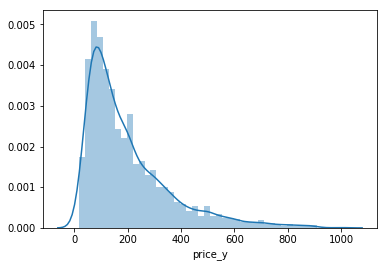

In [8]:
sb.distplot(y)

In [9]:
print 'Skew: ', y.skew()
print 'Kurtosis: ', y.kurtosis()
print(y.describe())

Skew:  1.6687972284562647
Kurtosis:  3.029010360718491
count    4001.000000
mean      199.608621
std       158.846621
min        18.000000
25%        85.000000
50%       149.324324
75%       263.078431
max       999.000000
Name: price_y, dtype: float64


Potential transformations on dependent variable: log power, power, etc.

In [ ]:
#do log - or use guidelines in stats book to decide power - then test models with 

Potentially use this for imputing price for y: http://scikit-learn.org/stable/modules/label_propagation.html

Looking at Outliers for Target Variable

In [10]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=20)
y_pred = clf.fit_predict(y.values.reshape(-1,1))
count = 0
for i in y_pred:
    if i<0:
        count=count+1
print 'Number of outliers: ', count
print 'Percentage of outliers: ', count/float(len(X))

Number of outliers:  401
Percentage of outliers:  0.100224943764


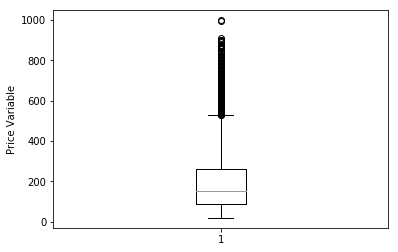

In [11]:
plt.boxplot(y)
plt.ylabel('Price Variable')
plt.show()

Insight: there are lots of outliers - as we have already seen, the price variable is skewed to the left

Choosing a basic set of independent variables for baseline regression

Note: think about potentially using modeling techniques to build this starting list 

e.g. we can start with top R2 contributors that are also uncorrelated of each other (but problem is can we rely on results of R2 contributions with all features?) 

e.g. can we use PCA to pick initial features?

Note: for now, to pick initial model feature candidates we evaluate a univariate regression with each regressor and pick the ones with the top R2. We use SKlearn for efficiency

In [119]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

In [120]:
X = X[X.columns.drop(X[list(X.filter(regex='Topic'))])]

In [121]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

In [122]:
from sklearn import preprocessing
#scaling is essential for PCA - otherwise accommodates gets 99% exp var
data_scaled = pd.DataFrame(preprocessing.scale(X),columns = X.columns) 

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/preprocessing/data.py:181: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [125]:
R2s = []
for col in X.columns:
    linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)
    regression_results = linear_regression.fit(X[col].values.reshape(-1, 1),y)
    #scores = cross_val_score(regression_results, data_scaled[col].values.reshape(-1, 1), y, cv=6)
    predictions = cross_val_predict(regression_results, X[col].values.reshape(-1, 1), y, cv=6)
    #accuracy = metrics.r2_score(y, predictions)
    R2s.append((col, r2_score(y, predictions)))#r2_score(y,regression_results.predict(data_scaled[col].values.reshape(-1,1))))) 

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [126]:
uni_r2 = pd.DataFrame(R2s, columns = ['col','R2']).sort_values(by='R2', ascending=False)

In [127]:
print 'Percentage of Univariate Regressions with positive R2: ', len(uni_r2[(uni_r2['R2']>0)])/float(len(uni_r2))

Percentage of Univariate Regressions with positive R2:  0.102209944751


Knowledge Check: R2 compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then R2 is negative. Note that R2 is not always the square of anything, so it can have a negative value without violating any rules of math. R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line. Update 5/6: seems like negative values have disappeared, probably was coding error 5/7 update: seems like many negative values are back now that we use CV

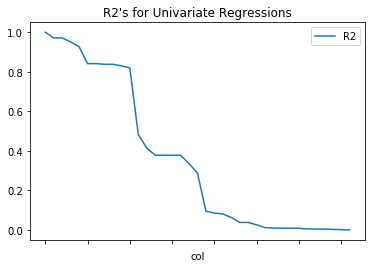

In [128]:
#Only going to look at positive R2's
pos_uni_r2 = uni_r2[uni_r2['R2']>0]
pos_uni_r2.plot(x='col',y='R2', title='R2\'s for Univariate Regressions')

In [129]:
pos_uni_r2

,col,R2
41,wkd_price,1.000000
21,median_price,0.971449
39,wkd_median_price,0.971449
35,wke_price,0.951111
33,wke_median_price,0.926927
40,wkd_min_price,0.841295
22,min_price,0.841295
20,max_price,0.837967
38,wkd_max_price,0.837967
34,wke_min_price,0.829951


Multivar Regression Methododology - Idea 1: we start with the highest R2 and build a univariate model. We then iteratively add features in order of univariate R2 importance, but we immediately filter them if they display high collinearity or correlation

An alternative to the approach above is to use the F-Test method to show univariate statistical significance and p values of each regressor (?)

In [23]:
X_acc = sm.add_constant(data_scaled['accommodates'].fillna(data_scaled['accommodates'].mean()))

In [24]:
OLS_accommodates_results = sm.OLS(y,X_acc).fit()

In [25]:
print(OLS_accommodates_results.summary())

                            OLS Regression Results                            
Dep. Variable:                price_y   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     5511.
Date:                Tue, 08 May 2018   Prob (F-statistic):               0.00
Time:                        00:11:11   Log-Likelihood:                -35517.
No. Observations:                5754   AIC:                         7.104e+04
Df Residuals:                    5752   BIC:                         7.105e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          204.7237      1.530    133.847   

The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A low p-value (< 0.05) indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable.
Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response.

Insight: the P value is very low, so we reject the null hypothesis that accommodates is not linearly associated with y
The Standard Error is relatively low

Plotting our Base Model

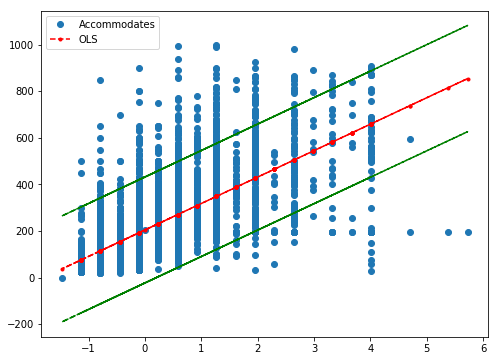

In [26]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(OLS_accommodates_results)

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(data_scaled['accommodates'], y, 'o', label="Accommodates")
ax.plot(data_scaled['accommodates'], OLS_accommodates_results.fittedvalues, 'r--.', label="OLS")
ax.plot(data_scaled['accommodates'], iv_u, 'g--')
ax.plot(data_scaled['accommodates'], iv_l, 'g--')
ax.legend(loc='best');

Getting to know the Accommodates variable better...

In [27]:
print 'Skew for original variable: ', X['accommodates'].skew()
print 'Kurtosis for original variable: ', X['accommodates'].kurtosis()
print(X['accommodates'].describe())

Skew for original variable:  1.5430335964345872
Kurtosis for original variable:  2.8706745500485376
count    5753.000000
mean        4.305232
std         2.916251
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        21.000000
Name: accommodates, dtype: float64


In [28]:
print 'Skew for scaled variable: ', data_scaled['accommodates'].skew()
print 'Kurtosis for scaled variable: ', data_scaled['accommodates'].kurtosis()
print(data_scaled['accommodates'].describe())

Skew for scaled variable:  1.5431676275184698
Kurtosis for scaled variable:  2.871694661332457
count    5.754000e+03
mean    -1.432446e-16
std      1.000087e+00
min     -1.476546e+00
25%     -7.906152e-01
50%     -1.046841e-01
75%      5.812471e-01
max      5.725731e+00
Name: accommodates, dtype: float64


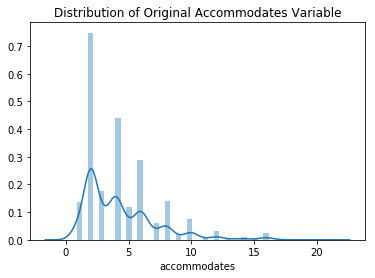

In [29]:
ax = plt.axes()
sb.distplot(X['accommodates'].fillna(X['accommodates'].mean()),ax=ax)
ax.set_title('Distribution of Original Accommodates Variable')
plt.show()

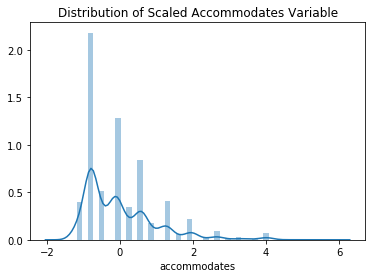

In [30]:
ax = plt.axes()
sb.distplot(data_scaled['accommodates'],ax=ax)
ax.set_title('Distribution of Scaled Accommodates Variable')
plt.show()

In [31]:
#going to only explore on scaled data now because that's what we'll use

Insight: the accommodates variable is actually a discrete variable. It is positively skewed (tail is to the right) with kurtosis lower than that of a normally distributed variable (i.e. lower probability of outliers)

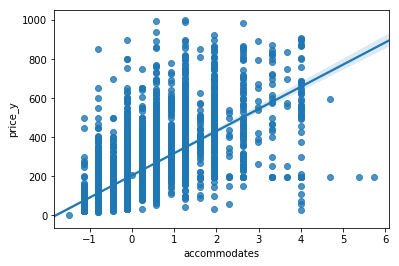

In [32]:
dat = pd.concat([pd.DataFrame(data_scaled['accommodates']),pd.DataFrame(y)],axis=1)
sb.regplot(x="accommodates", y="price_y", data=dat);

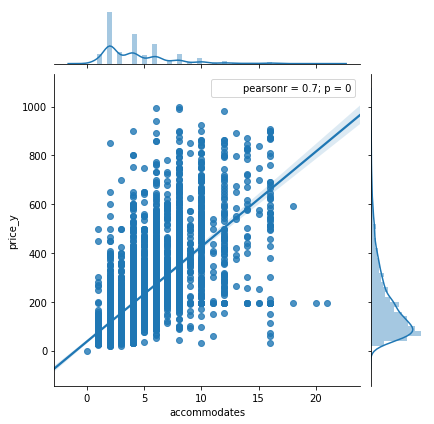

In [33]:
dat = pd.concat([pd.DataFrame(data_scaled['accommodates']),pd.DataFrame(y)],axis=1)
sb.jointplot(x="accommodates", y="price_y", data=listings, kind="reg");

Now testing the ML errors for Linear Regression before we start multivar regressions

In [105]:
def univar_linear_regression(X, y, model_description):
    model_description = str(model_description)
    model = linear_model.LinearRegression(normalize=True, fit_intercept=True)
    model_results = model.fit(X,y)
    predictions = cross_val_predict(model_results, X, y, cv=6)
    print 'Model Description: ', model_description
    print 'R2 Score: ', r2_score(y, predictions)
    print 'Regression Coefficiencts %s' %(model_results.coef_)
    print 'Regression Features: %s' %([i for i in X.columns])
    print 'The mean squared error is ' + str(mean_squared_error(predictions, y))
    print 'The RMSE for validation is: ' + str(np.sqrt(mean_squared_error(predictions, y)))
    print 'The mean absolute error for validation is ' + str(mean_absolute_error(predictions, y))
    SSE = pd.Series(y - y.mean())**2
    print 'SSE: ', sum(SSE)
    
    SSE.plot('hist')
    plt.title('Frequency Distribution of SSE')
    plt.show()
    
    indx = [i for i in range(0,len(X.columns))]
    
    #Residuals
    for var,idx in zip(X.columns,indx):
        residuals = y - predictions
        sb.distplot(residuals)
        plt.show()
        
    #Partial Residuals
    for var,idx in zip(X.columns,indx):
        residuals = y - predictions
        partial_residual = residuals + X[var]*model.coef_[idx]
        plt.plot(X[var], partial_residual, 'x')
        plt.xlabel(var)
        plt.ylabel('Partial Residuals')
        plt.show()


Model Description:  Simple univariate linear model with Accommodates feature - used as baseline because it had the highest R2
R2 Score:  0.4826124045809871
Regression Coefficiencts [  0.         113.54679974]
Regression Features: ['const', 'accommodates']
The mean squared error for validation is 13632.909350168733
The mean absolute error for validation is 77.94197983147038
SSE:  151615077.546


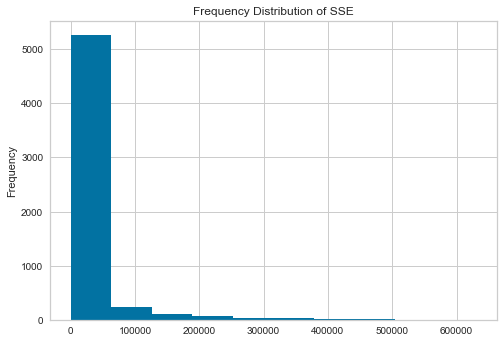

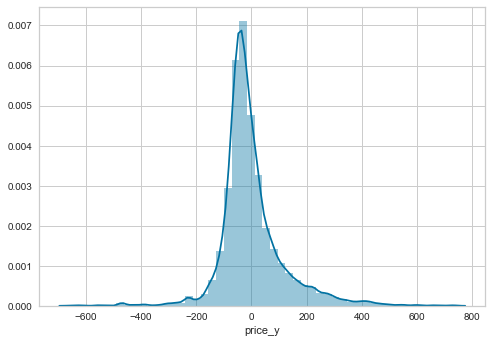

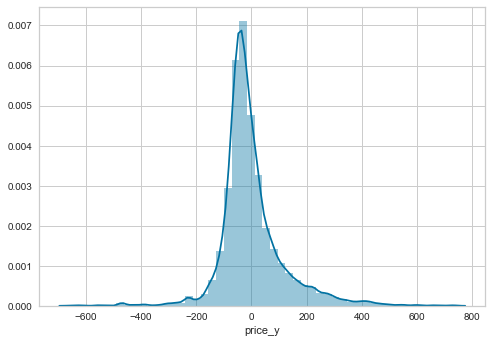

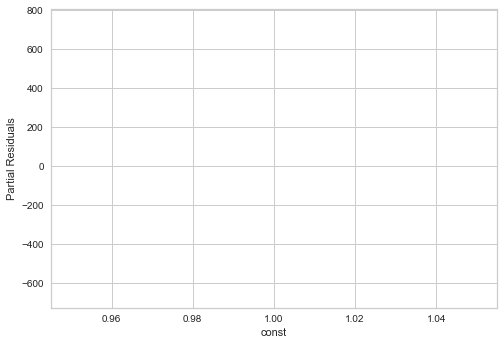

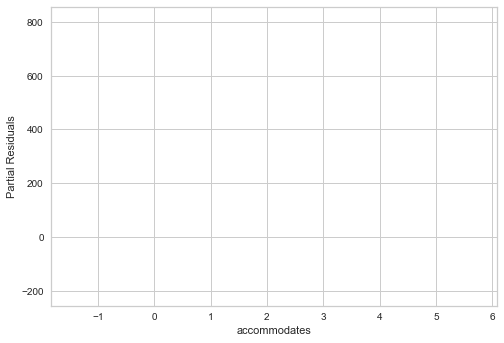

In [106]:
univar_linear_regression(X_acc, y, "Simple univariate linear model with Accommodates feature - used as baseline because it had the highest R2")

Partial Residuals

Methodologies for selecting the next best feature: RFECV, Pearson Corr, Lasso Lars Ranking, Ridge Ranking,  

In [82]:
#using only the features that had a univariate positive R2 
ps_features = [i for i in pos_uni_r2['col']]

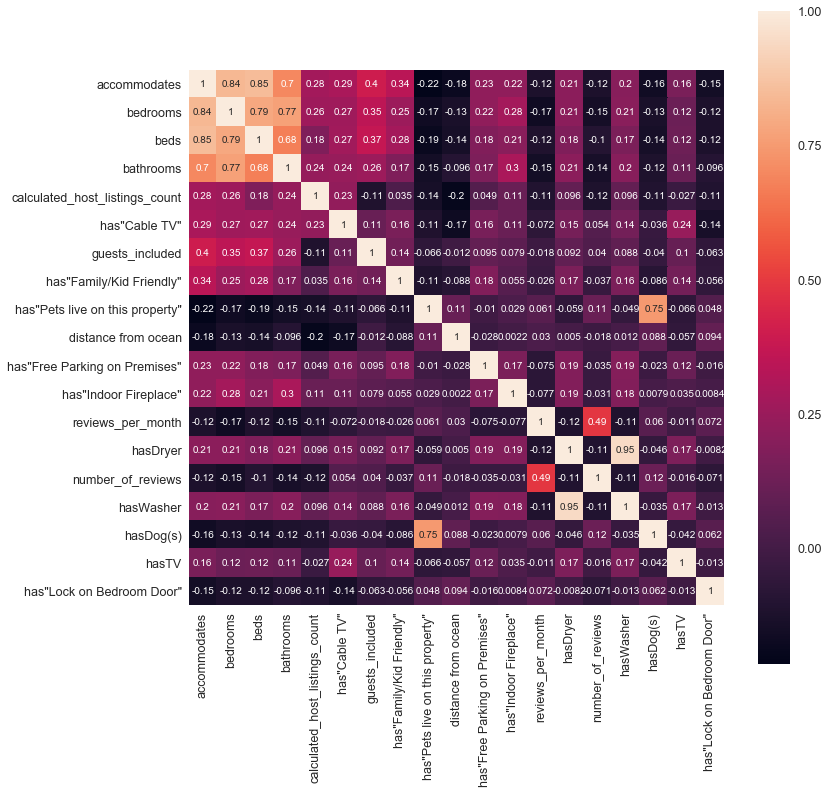

In [89]:
cm = np.corrcoef(data_scaled[ps_features].values.T)
sb.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(12,12))
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size':10}, yticklabels=ps_features, xticklabels=ps_features)
plt.show()

Insight: Solely based on correlations and R2, I am picking calculated_host_listings_count as first choice to try multivar regression. However, let's see how other feature importance methods rank the features first

Shapiro Ranking

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/stats/morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


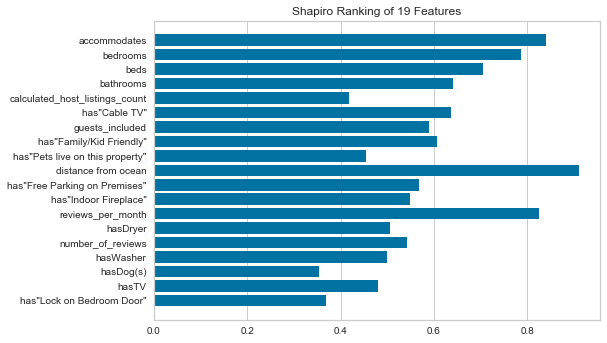

In [90]:
from yellowbrick.features import Rank1D
visualizer = Rank1D(features=data_scaled[ps_features].columns, algorithm='shapiro')
visualizer.fit(data_scaled[ps_features], y) # Fit the data to the visualizer
visualizer.transform(data_scaled[ps_features]) # Transform the data
visualizer.poof()

Lasso Lars L1 Regularization for Feature Ranking

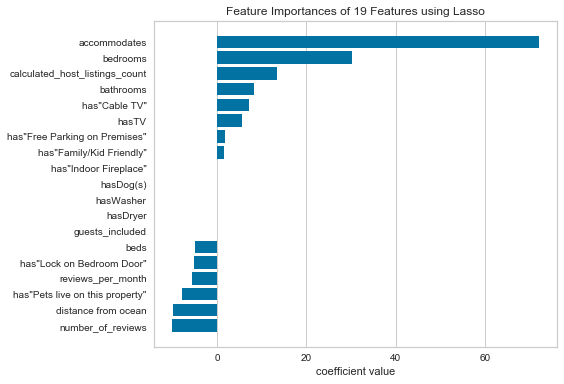

In [95]:
from sklearn.linear_model import Lasso
from yellowbrick.features.importances import FeatureImportances
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(Lasso(), ax=ax, labels=data_scaled[ps_features].columns, relative=False)
# Fit and show the feature importances
viz.fit(data_scaled[ps_features], y)
viz.poof()

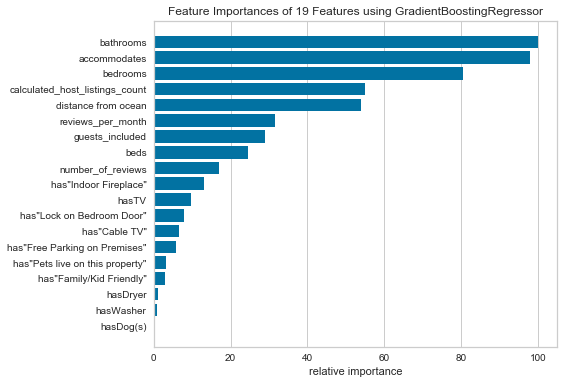

In [96]:
from sklearn.ensemble import GradientBoostingRegressor
fig = plt.figure()
ax = fig.add_subplot()
viz = FeatureImportances(GradientBoostingRegressor(), ax=ax)
viz.fit(data_scaled[ps_features], y)
viz.poof()

In [ ]:
#now do the the multivar regressions

Checking OLS assumptions and analysis of residuals

Analysis of Residuals for Accommodates

In [183]:
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(OLS_accommodates_results.resid)
lzip(name, test)

[('Jarque-Bera', 9012.693961037914),
 ('Chi^2 two-tail prob.', 0.0),
 ('Skew', 1.0577139524284396),
 ('Kurtosis', 8.75473845356843)]

In [184]:
name = ['Chi^2', 'Two-tail probability']
test = sms.omni_normtest(OLS_accommodates_results.resid)
lzip(name, test)

[('Chi^2', 1450.8958273927547), ('Two-tail probability', 0.0)]

In [185]:
from statsmodels.graphics.regressionplots import plot_leverage_resid2

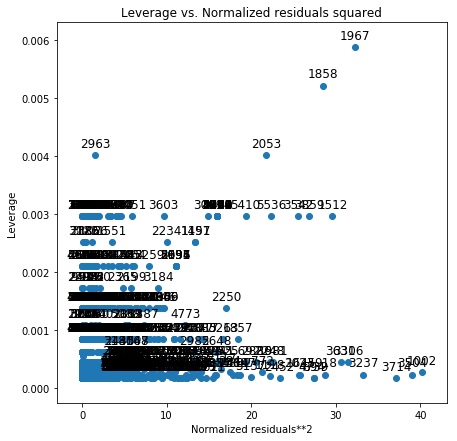

In [187]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_leverage_resid2(OLS_accommodates_results, ax = ax)
plt.show()

Insights: certain listings have high error and also high leverage on the model - look at each and consider transformations or omitting them from the data - investigate them!

In [171]:
SSE_accommodates = pd.Series(y.mean() - y)**2

In [177]:
accommodates_residuals = y - linear_regression.fit(X['accommodates'].values.reshape(-1,1),y).predict(X['accommodates'].values.reshape(-1,1))
print("SSE for Accommodates: %0.5f " %sum(SSE_accommodates))
print("Mean of Residuals: %0.3f" %np.mean(accommodates_residuals))
print("Standard Deviation of Residuals: %0.3f" %(np.std(accommodates_residuals)))

SSE for Accommodates: 151615077.54615 
Mean of Residuals: -0.000
Standard Deviation of Residuals: 116.003


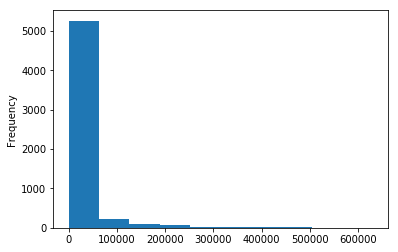

In [178]:
SSE_accommodates.plot('hist')

Insight: the mean of residuals is zero, a fundamental assumption of Linear Regression

Now we plot the residuals with the target variable and check whether if there is any correlation

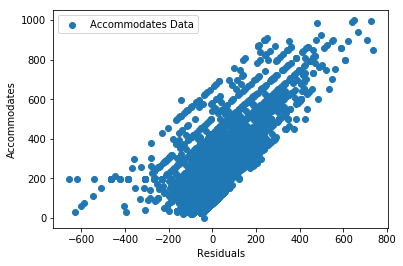

In [169]:
plt.scatter(x=accommodates_residuals,y=y, label='Accommodates Data')
plt.xlabel("Residuals")
plt.ylabel("Accommodates")
plt.legend(loc=2)
plt.show()

Insight: the residuals increase linearly as Accommodates increase - this is a problemm(?)

Heteroskedasticity Tests and Plot

It is customary to check for heteroscedasticity of residuals once you build the linear regression model. The reason is, we want to check if the model thus built is unable to explain some pattern in the response variable Y, that eventually shows up in the residuals. This would result in an inefficient and unstable regression model that could yield bizarre predictions later on.
For these test the null hypothesis is that all observations have the same error variance, i.e. errors are homoscedastic. The tests differ in which kind of heteroscedasticity is considered as alternative hypothesis. They also vary in the power of the test for different types of heteroscedasticity.

Breush-Pagan test: It tests whether the variance of the errors from a regression is dependent on the values of the independent variables. In that case, heteroskedasticity is present.
If the test statistic has a p-value below an appropriate threshold (e.g. p<0.05) then the null hypothesis of homoskedasticity is rejected and heteroskedasticity assumed.

In [188]:
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
test = sms.het_breushpagan(OLS_accommodates_results.resid, OLS_accommodates_results.model.exog)
lzip(name, test)

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `het_breushpagan` is deprecated, use `het_breuschpagan` instead!
Use het_breuschpagan, het_breushpagan will be removed in 0.9 
(Note: misspelling missing 'c')
  This is separate from the ipykernel package so we can avoid doing imports until


[('Lagrange multiplier statistic', 806.2906570933038),
 ('p-value', 2.314012401764704e-177),
 ('f-value', 937.3598039362726),
 ('f p-value', 7.610210108375734e-191)]

In [189]:
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(OLS_accommodates_results.resid, OLS_accommodates_results.model.exog)
lzip(name, test)

[('F statistic', 0.7437983466637724), ('p-value', 0.9999999999999988)]

Enter Insights from the above tests:

Now Plotting Heteroskedasticity

In [195]:
from statsmodels.graphics.regressionplots import plot_regress_exog

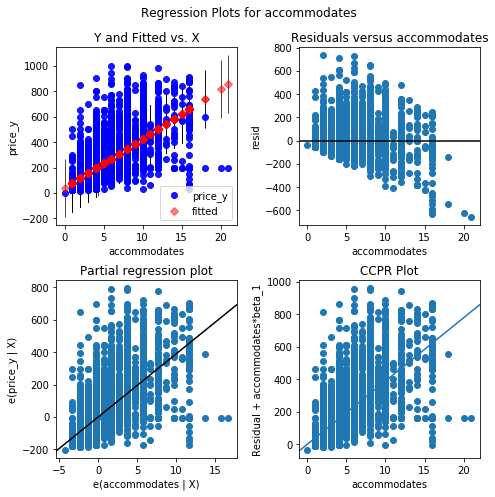

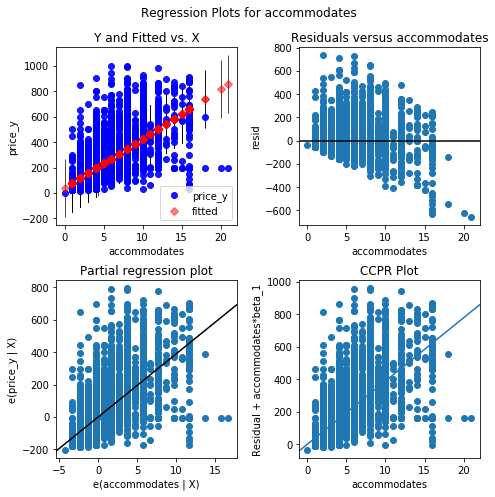

In [199]:
fig = plt.figure(figsize=(7,7))
plot_regress_exog(OLS_accommodates_results, 1, fig=fig)

Component-Component plus Residual (CCPR) Plots
The CCPR plot provides a way to judge the effect of one regressor on the 
response variable by taking into account the effects of the other 
independent variables. The partial residuals plot is defined as 
Residuals+BiXi    versus  Xi . The component adds  BiXi  versus 
Xi  to show where the fitted line would lie. Care should be taken if  Xi  
is highly correlated with any of the other independent variables. If this 
is the case, the variance evident in the plot will be an underestimate of 
the true variance.

Note: will have to use CCPR with multivar regression

Plot variance of error terms?

In [ ]:
#do it here

Autocorrelation of residuals:

In [ ]:
#do it here

Correlation between Residuals and Independent Variable

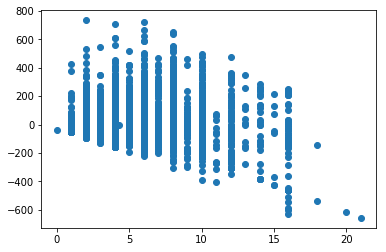

In [170]:
plt.scatter(x=X_1['accommodates'], y=accommodates_residuals)

Insight: there is an inverse relationship between the error terms and Accommodates - This pattern indicates that at least another variable with statistically significant impact on y has been ommitted (we shall find some in multivariate regression!)

Are the residuals normally distributed? (yes they are - see below)

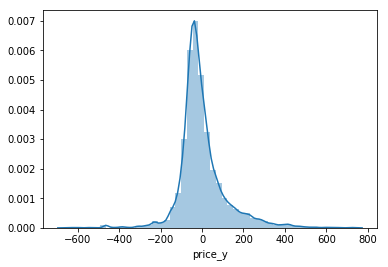

In [164]:
sb.distplot(accommodates_residuals)

Residuals vs. Fitted Values

In [23]:
plt.plot(linear_regression.predict(X['accommodates'].values.shape(-1,1)), accommodates_residuals, 'Accommodates')
plt.ylabel('Residuals')
plt.xlabel('FItted Values')
plt.show()

NameError: name 'linear_regression' is not defined

Multivariate Regressions

Pick next regressors to add to accommodates: identify methodology for getting next best regressor - one might be PCR, another feature importanve with RCEFV, LASSO, RIDGE, CORRELATION, etc. (look at visualizations nb)

Look at correlations

In [ ]:
corrmx = master_num.corr()
f, ax = plt.subplots(figsize=(18,18))
sb.heatmap(corrmx, vmax=.9, square=True)

In [ ]:
columns = corrmx.nlargest(10,'review_scores_rating')['review_scores_rating'].index
cm = np.corrcoef(master_num[columns].values.T)
sb.set(font_scale=1.25)
hm = sb.heatmap(cm, cbar=True, annot=True, square=True, annot_kws={'size':10}, yticklabels=columns.values, xticklabels=columns.values)
plt.show()

Plot the regressors chosen with respect to one another (use below scatter matrix and get more in viz nb)

In [ ]:
"""scatter_matrix(X[['accommodates', 'bedrooms', 'bathrooms', 'beds']], alpha=0.2, figsize=(7, 7), diagonal='kde')
plt.show()"""

Analyze Multicollinearity and Residuals with Multiple variables

Use Variance Inflation Factor to seek collinearity among variables

Error and Residual Analysis for MultiVar regression:
    look at partial residuals

First, normalize the features to better compare coefficients and interpret their importance. Then, use Lasso Lars and Ridge Regression to look at importance of Features by checking the coefficients the models will output
http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/

Also use this module to give statistics for the regressors: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_regression.html

Finally, replicate Recursive Feature Elimination http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

Note: Had done PCA Analysis, since it's probably not going to be useful will leave it down here

Running a PCA Update 5/6 Was going to use it for feature selection but probably won't

In [63]:
from sklearn.decomposition import PCA

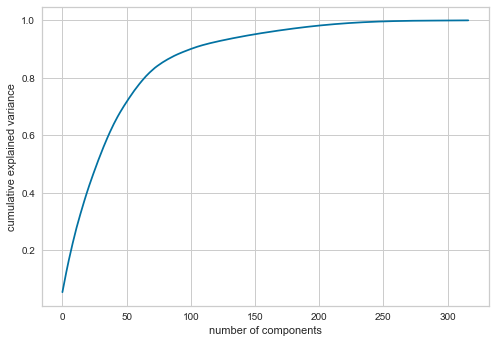

In [75]:
#Now using all components to see how explained var ratio behaves as number of components increses
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Insight: we probably would want to keep at least the top 50 components but for now we will begin with a regression with the top 10 and later add those iteratively

In [89]:
n_comps = 50
pca = PCA(n_components=n_comps)
model_fit = pca.fit(data_scaled)
X_transform = model_fit.transform(data_scaled)
print'Score for PCA with %i Components: %i' %(n_comps,model_fit.score(data_scaled))

Score for PCA with 50 Components: -344


In [90]:
n_comps = 10
pca = PCA(n_components=n_comps)
model_fit = pca.fit(data_scaled)
X_transform = model_fit.transform(data_scaled)
print'Score for PCA with %i Components: %i' %(n_comps,model_fit.score(data_scaled))

Score for PCA with 10 Components: -377


In [91]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print 'Explained Variance: '
print pd.Series(model_fit.explained_variance_)
print '\n'
print 'Explained Variance Ratio: '
print pd.Series(model_fit.explained_variance_ratio_)

Explained Variance: 
0   61.116
1   17.177
2   13.649
3    7.495
4    6.391
5    5.894
6    5.591
7    4.996
8    4.566
9    3.647
dtype: float64


Explained Variance Ratio: 
0   0.198
1   0.056
2   0.044
3   0.024
4   0.021
5   0.019
6   0.018
7   0.016
8   0.015
9   0.012
dtype: float64


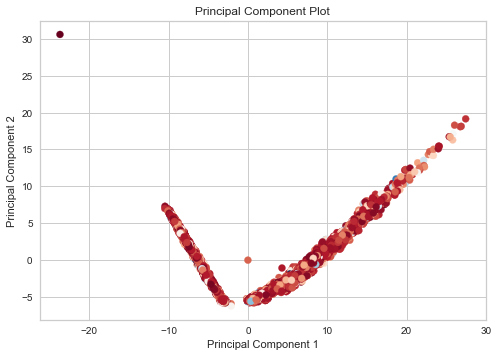

In [95]:
from yellowbrick.features.pca import PCADecomposition
visualizer = PCADecomposition(n_components=10, scale=False, color=y)
visualizer.fit(data_scaled)
visualizer.transform(data_scaled)
visualizer.poof()

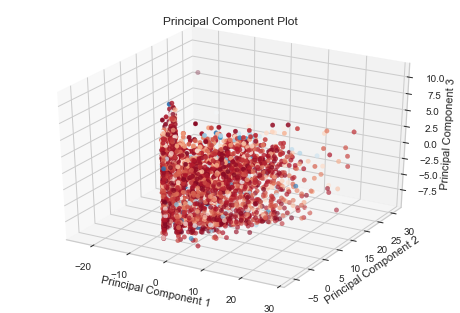

In [98]:
visualizer = PCADecomposition(scale=False,n_components=10, proj_dim=3, color = y)
visualizer.fit(data_scaled)
visualizer.transform(data_scaled)
visualizer.poof()

In [110]:
var = pd.DataFrame(model_fit.components_,columns=data_scaled.columns)

Insight: stopping here because I don't think I can do feature selection based on PCA. However, going to try Princ Components Regression below...

In [56]:
#Princ Compo Regression